> ### Problem: Adversarial Noise (from the author's description)
>The task involves developing a program that manipulates images by adding adversarial noise. This noise is designed to trick an image classification model into misclassifying the altered image as a specified target class, regardless of the original content.
> - You may select any pre-trained image classification model for this task. A model from the torchvision library is recommended, but not mandatory.
> - The core challenge is to effectively introduce noise into the image in such a way that the model misclassifies it as the desired target class, without making the noise perceptible to a casual human viewer.





### 0.1 Getting Started

The goal of the challenge is to develop a program that adds adversarial noise to images with the aim of tricking an image classification model without being detected by a human. 

More formally, consider that $\mathcal{D} = \{ (x_i, y_i) \}_{i=1}^N$ is a dataset of images and their corresponding labels. Let also $f_{\theta}: \mathcal{X} \to \mathcal{Y}$ be a pre-trained image classification model with estimated parameters $\theta$, where $\mathcal{X}$ is the space of images and $\mathcal{Y}$ is the space of labels that achieves $a%$ accuracy a dataset. The goal is to find an adversarial noise $\epsilon$ such that the model misclassifies the image $x_i$:

$$
\epsilon^* = \arg\min_{\epsilon} \frac{1}{N} \sum_{i=1}^N \mathbb{I}\Big(f_{\theta}(x_i + \epsilon) = y_i\Big)
$$

Thus, we have the following model components:

1. **Dataset**: A collection of images and their corresponding labels.
2. **Model**: A pre-trained image classification model that can be used to classify images.
3. **Adversarial Noise**: A perturbation that can be added to the images

This will guide the development of the solution thorough this notebook.

### 0.2 Dataset

The dataset used in this challenge is the 
[Tiny ImageNet]("https://www.kaggle.com/c/tiny-imagenet") dataset, which is a subset of the full ImageNet dataset designed for faster experimentation and academic research. 
Tiny ImageNet contains 200 classes, each corresponding to a WordNet ID (WNID), with 500 training images per class.

The images are color images of size 64×64 pixels, significantly smaller than the 
original ImageNet 224×224 images, making it more manageable for limited compute resources.

The dataset is organized as follows:
- **Training set:** 100,000 images (500 images × 200 classes)
- **Validation set:** 10,000 images (50 images × 200 classes)
- **Test set:** 10,000 images (50 images × 200 classes, labels withheld)

Each class folder contains an <code>images/</code> directory with the raw images and an <code>annotation.txt</code> file describing bounding boxes for the objects. Class code (WNIDs) can be mapped to human-readable class names using the provided <code>words.txt</code> file.

We start by visualizing a few sample images from the dataset to better understand its characteristics and diversity.

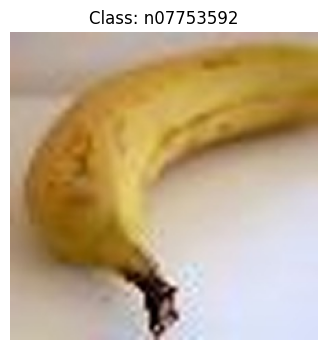

In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# --- Path to Tiny ImageNet 224 ---
data_path = os.path.join(os.getcwd(), "data", "inputs", "tiny-224")

# --- Train folder ---
train_path = os.path.join(data_path, "train")

# --- Get all class directories ---
classes = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]

# --- Pick a random class and a random image ---
random.seed(19940202)
random_class = random.choice(classes)
images_dir = os.path.join(train_path, random_class, "images")  # folder structure: train/WNID/images
image_files = os.listdir(images_dir)
random_image_file = random.choice(image_files)
image_path = os.path.join(images_dir, random_image_file)

# --- Load and display the image ---
img = Image.open(image_path).convert("RGB")

plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title(f"Class: {random_class}")
plt.axis('off')
plt.show()

Below we have the description of each of the classes of the tiny imagenet dataset:

In [6]:
import os

# --- Path to Tiny ImageNet 224 root folder ---
data_path = os.path.join(os.getcwd(), "data", "inputs", "tiny-224")

# --- Load WordNet ID to human-readable label mapping ---
words_path = os.path.join(data_path, "words.txt")
id_to_label = {}

with open(words_path, 'r') as f:
    for line in f:
        wnid, label = line.strip().split('\t')
        id_to_label[wnid] = label

# --- Get classes directly from train folder ---
train_path = os.path.join(data_path, "train")
wnids = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])

# --- Print mapping for all classes ---
print(f"Total classes: {len(wnids)}\n")
for wnid in wnids:
    human_label = id_to_label.get(wnid, "Unknown class")
    print(f"{wnid} -> {human_label}")


Total classes: 200

n01443537 -> goldfish, Carassius auratus
n01629819 -> European fire salamander, Salamandra salamandra
n01641577 -> bullfrog, Rana catesbeiana
n01644900 -> tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 -> American alligator, Alligator mississipiensis
n01742172 -> boa constrictor, Constrictor constrictor
n01768244 -> trilobite
n01770393 -> scorpion
n01774384 -> black widow, Latrodectus mactans
n01774750 -> tarantula
n01784675 -> centipede
n01855672 -> goose
n01882714 -> koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus
n01910747 -> jellyfish
n01917289 -> brain coral
n01944390 -> snail
n01945685 -> slug
n01950731 -> sea slug, nudibranch
n01983481 -> American lobster, Northern lobster, Maine lobster, Homarus americanus
n01984695 -> spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish
n02002724 -> black stork, Ciconia nigra
n02056570 -> king penguin, Aptenodytes patagonica
n02058221 -> albatross, mollyma

### 0.3 Pre-Trained Model

For this challenge, we leverage ImageNet pre-trained models, which are trained on 1,000 object classes from the ImageNet dataset (over 14 million images). These models achieve around 70–80% top-1 accuracy and ~90% top-5 accuracy on the ImageNet test set.

Although they are not state-of-the-art, they provide an excellent starting point because:

1. They learn general visual features that transfer well to new tasks.
2. They reduce training time and computational cost via transfer learning.
3. They can be fine-tuned on specific tasks with limited data.
4. They offer strong baseline performance for image recognition experiments.

This makes them well-suited for the initial phase of the task at hand, before considering more advanced architectures.


In [8]:
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont

dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
import json
import urllib.request

# --- Paths ---
data_dir = os.path.join(os.getcwd(), "data", "inputs", "tiny-224")
test_dir = os.path.join(data_dir, "test")

# --- Step 1: Load ImageNet class index mapping to WNIDs ---
# Download if not available
json_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_class_index.json"
json_path = "imagenet_class_index.json"
if not os.path.exists(json_path):
    urllib.request.urlretrieve(json_url, json_path)

with open(json_path, "r") as f:
    idx_to_wnid = {int(k): v[0] for k, v in json.load(f).items()}  # idx -> wnid


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm

# --- Transformations for ResNet ---
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Load test dataset ---
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of test images: {len(test_dataset)}")
print(f"Number of test classes: {len(test_dataset.classes)}")

# --- Step 2: Build mapping from Tiny ImageNet class to ImageNet 1k index ---
tiny_classes = test_dataset.classes  # list of folder names, e.g., ['n01443537', ...]
wnid_to_idx = {wnid: idx for idx, wnid in idx_to_wnid.items()}

# Map Tiny ImageNet label index -> ImageNet 1k index
tiny_to_imagenet_idx = []
for wnid in tiny_classes:
    if wnid not in wnid_to_idx:
        print(f"Warning: WNID {wnid} not in ImageNet 1k classes (will be ignored).")
        tiny_to_imagenet_idx.append(None)
    else:
        tiny_to_imagenet_idx.append(wnid_to_idx[wnid])

# --- Load pretrained ResNet18 (1,000 classes) ---
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT).to(device)
# model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
# Replace final layer for 200 classes (Tiny ImageNet)
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 200)
model.eval()

# --- Prediction Loop ---
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Pre-trained Model...", unit="batch"):
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # ImageNet indices (0-999)

        # Map Tiny ImageNet labels -> ImageNet 1k indices
        mapped_labels = [tiny_to_imagenet_idx[label.item()] for label in labels]

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(mapped_labels)

# Remove samples whose class is not in ImageNet 1k
mask = [t is not None for t in all_targets]
all_preds = np.array(all_preds)[mask]
all_targets = np.array([t for t in all_targets if t is not None])

# --- Compute Top-1 Accuracy ---
accuracy = (all_preds == all_targets).mean()
print(f"Top-1 Accuracy (ImageNet mapping): {accuracy*100:.2f}%")

Number of test images: 5000
Number of test classes: 200


Evaluating Pre-trained Model...: 100%|██████████| 157/157 [17:05<00:00,  6.53s/batch]

Top-1 Accuracy (ImageNet mapping): 0.04%


In [21]:
(all_preds == all_targets)

array([False, False, False, ..., False, False, False], shape=(5000,))

In [18]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([ 8.3914,  9.4163, 12.8108,  8.3334, 11.8376,  9.4676,  9.3006, 10.1897,
         7.9651, 10.2452,  9.6569, 11.3618,  8.8197, 10.4711, 10.8379, 10.6856,
         7.7305,  7.7939,  9.8858, 10.3597, 12.6918, 10.1931, 12.9095, 10.1129,
         7.7259, 11.5688, 11.0694, 16.9403, 12.4504, 15.5533,  7.1962, 13.4737]),
indices=tensor([186, 187,  73, 220, 191, 683,  73, 335,  73, 175, 186, 364, 335, 158,
        186, 194,  73, 683,  68, 335, 175, 335, 188, 584, 187, 262, 192, 187,
        185, 185, 210, 262]))

In [49]:
import os
import torch
from torchvision import models
from torchvision.models import AlexNet_Weights
from PIL import Image
from tqdm import tqdm

# Paths
data_path = os.path.join(os.getcwd(), "data", "inputs", "tiny-imagenet-200")
val_images_dir = os.path.join(data_path, "val", "images")
val_annotations_file = os.path.join(data_path, "val", "val_annotations.txt")
loc_synset_file = os.path.join(data_path, "words.txt")

print(f"Data path: {data_path}")
print(f"LOC synset file exists: {os.path.exists(loc_synset_file)}")

# Load ImageNet-1k class index to WNID mapping from LOC_synset_mapping.txt
print("Loading ImageNet-1k class to WNID mapping...")
imagenet_idx_to_wnid = {}
with open(loc_synset_file, "r") as f:
    for idx, line in enumerate(f):
        parts = line.strip().split()
        if len(parts) >= 1:
            wnid = parts[0]  # First part is the WNID (e.g., n01440764)
            imagenet_idx_to_wnid[idx] = wnid

print(f"Loaded {len(imagenet_idx_to_wnid)} ImageNet-1k class mappings")

# Create reverse mapping: WNID -> ImageNet class index
imagenet_wnid_to_idx = {wnid: idx for idx, wnid in imagenet_idx_to_wnid.items()}

# Load validation labels
val_labels = {}
with open(val_annotations_file, "r") as f:
    for line in f:
        img_name, wnid = line.strip().split("\t")[:2]
        val_labels[img_name] = wnid

# Load Tiny ImageNet WNIDs
with open(os.path.join(data_path, "wnids.txt"), "r") as f:
    tiny_wnids = [line.strip() for line in f]

print(f"Tiny ImageNet classes: {len(tiny_wnids)}")
print(f"Validation images: {len(val_labels)}")

# Find overlapping classes between Tiny ImageNet and ImageNet-1k
overlapping_wnids = set(tiny_wnids) & set(imagenet_wnid_to_idx.keys())
print(f"Overlapping classes: {len(overlapping_wnids)}")

if len(overlapping_wnids) == 0:
    print("ERROR: No overlapping classes found!")
    print("Sample Tiny ImageNet WNIDs:", tiny_wnids[:5])
    print("Sample ImageNet WNIDs:", list(imagenet_wnid_to_idx.keys())[:5])
    exit(1)

# Create mapping for evaluable classes: WNID -> ImageNet class index
evaluable_wnids = {}
for wnid in overlapping_wnids:
    evaluable_wnids[wnid] = imagenet_wnid_to_idx[wnid]

print(f"Can evaluate {len(evaluable_wnids)} classes accurately")
print("Sample overlapping classes:")
for i, (wnid, idx) in enumerate(list(evaluable_wnids.items())[:5]):
    print(f"  {wnid} -> ImageNet class {idx}")

# Load pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = AlexNet_Weights.DEFAULT
model = models.alexnet(weights=weights)
model.eval().to(device)
transform = weights.transforms()

print(f"\nDevice: {device}")
print(f"Starting evaluation...")

# Evaluate
correct = 0
total = 0
evaluable = 0  # Count of images with classes that exist in ImageNet-1k
batch_size = 32

image_files = list(val_labels.keys())

for i in tqdm(range(0, len(image_files), batch_size), desc="Evaluating"):
    batch_files = image_files[i:i+batch_size]
    batch_images = []
    batch_expected_indices = []
    
    # Load batch
    for img_file in batch_files:
        img_path = os.path.join(val_images_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        batch_images.append(transform(img))
        
        # Check if this class can be evaluated
        gt_wnid = val_labels[img_file]
        if gt_wnid in evaluable_wnids:
            expected_imagenet_idx = evaluable_wnids[gt_wnid]
            batch_expected_indices.append(expected_imagenet_idx)
            evaluable += 1
        else:
            batch_expected_indices.append(-1)  # Mark as non-evaluable
        
        total += 1
    
    # Forward pass
    inputs = torch.stack(batch_images).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, predictions = outputs.max(1)
    
    # Check accuracy (only for evaluable classes)
    for pred_idx, expected_idx in zip(predictions.cpu(), batch_expected_indices):
        if expected_idx != -1:  # Only count evaluable classes
            if pred_idx.item() == expected_idx:
                correct += 1

# Results
coverage = evaluable / total if total > 0 else 0
accuracy_on_evaluable = correct / evaluable if evaluable > 0 else 0
overall_accuracy = correct / total if total > 0 else 0

print(f"\n" + "="*50)
print(f"EVALUATION RESULTS")
print(f"="*50)
print(f"Total images processed: {total}")
print(f"Images with evaluable classes: {evaluable}")
print(f"Coverage (evaluable/total): {coverage:.2%}")
print(f"Correct predictions: {correct}")
print(f"Accuracy on evaluable classes: {accuracy_on_evaluable:.4f} ({accuracy_on_evaluable*100:.2f}%)")
print(f"Overall accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

print(f"\nInterpretation:")
print(f"- Coverage shows what % of Tiny ImageNet classes exist in ImageNet-1k")
print(f"- Accuracy on evaluable classes is the true performance metric")
print(f"- This measures how well ImageNet features transfer to Tiny ImageNet")

Data path: /Users/danieloliveira/Documents/Daniel/codes/leap-challenge/src/data/inputs/tiny-imagenet-200
LOC synset file exists: True
Loading ImageNet-1k class to WNID mapping...
Loaded 82115 ImageNet-1k class mappings
Tiny ImageNet classes: 200
Validation images: 10000
Overlapping classes: 200
Can evaluate 200 classes accurately
Sample overlapping classes:
  n02321529 -> ImageNet class 12207
  n02281406 -> ImageNet class 11980
  n03992509 -> ImageNet class 22062
  n04456115 -> ImageNet class 24845
  n03544143 -> ImageNet class 19413

Device: cpu
Starting evaluation...


Evaluating: 100%|██████████| 313/313 [01:19<00:00,  3.95it/s]


EVALUATION RESULTS
Total images processed: 10000
Images with evaluable classes: 10000
Coverage (evaluable/total): 100.00%
Correct predictions: 0
Accuracy on evaluable classes: 0.0000 (0.00%)
Overall accuracy: 0.0000 (0.00%)

Interpretation:
- Coverage shows what % of Tiny ImageNet classes exist in ImageNet-1k
- Accuracy on evaluable classes is the true performance metric
- This measures how well ImageNet features transfer to Tiny ImageNet


In [36]:
total

10000

In [35]:
correct

0